In [23]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import os
import time

In [24]:
# Creating and converting dataset to tensorflow
path = tf.keras.utils.get_file('dracula.txt', 'http://www.gutenberg.org/cache/epub/345/pg345.txt')
text = open(path, 'rb').read().decode(encoding='utf-8')
vocabulary = sorted(set(text))
vocabulary_size = len(vocabulary)

In [25]:
# map unique characters to indices and vice versa
charMapping = {u:i for i, u in enumerate(vocabulary)}
indiceMapping = np.array(vocabulary)
text_as_int = np.array([charMapping[c] for c in text])

sequence_length = 100
examples_per_epoch = len(text)//sequence_length # floor division
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(sequence_length+1, drop_remainder=True)

num_of_characters = len(text)
num_of_vocabulary = len(vocabulary)
print("Total Characters: ", num_of_characters)
print("Total Vocabulary: ", num_of_vocabulary)

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

Total Characters:  883114
Total Vocabulary:  102


In [26]:
BATCH_SIZE = 512
steps_per_epoch = examples_per_epoch//BATCH_SIZE # floor division
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [27]:
# Build model
embedding_dimension = 256
rnn_units = 1024

lstm = tf.keras.layers.CuDNNLSTM # fast LSTM implementation backed by cuDNN

def build_model(vocab_size, embedding_dim, units, batch_size, drop_out):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]), # Input layer
    lstm(rnn_units, # Hidden layer 1
        return_sequences=True, 
        recurrent_initializer='lecun_uniform',
        stateful=True),
    tf.keras.layers.Dropout(drop_out),
    lstm(rnn_units, # Hidden layer 2
        return_sequences=True, 
        recurrent_initializer='lecun_uniform',
        stateful=True),
    tf.keras.layers.Dropout(drop_out),
    tf.keras.layers.Dense(vocab_size) # Output layer
  ])
  return model

model = build_model(
  vocab_size = vocabulary_size, 
  embedding_dim=embedding_dimension, 
  units=rnn_units, 
  batch_size=BATCH_SIZE,
  drop_out=0.2)

In [28]:
# Validate the model
for input_example_batch, target_example_batch in dataset.take(1): 
  example_batch_predictions = model(input_example_batch)
  
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [29]:
# Train the model
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

model.compile(tf.train.AdamOptimizer(), loss=loss)

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

EPOCHS=20
history = model.fit(dataset.repeat(), epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=[checkpoint_callback])

Prediction shape:  (512, 100, 102)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.622997
Epoch 1/20
17/17 [==============================] - 15s 866ms/step - loss: 3.4366
Epoch 2/20
17/17 [==============================] - 14s 805ms/step - loss: 3.1637
Epoch 3/20
17/17 [==============================] - 14s 806ms/step - loss: 3.1454
Epoch 4/20
17/17 [==============================] - 14s 806ms/step - loss: 3.1079
Epoch 5/20
17/17 [==============================] - 14s 812ms/step - loss: 2.9423
Epoch 6/20
17/17 [==============================] - 14s 797ms/step - loss: 2.7207
Epoch 7/20
17/17 [==============================] - 14s 814ms/step - loss: 2.5450
Epoch 8/20
17/17 [==============================] - 14s 797ms/step - loss: 2.4323
Epoch 9/20
17/17 [==============================] - 13s 780ms/step - loss: 2.3593
Epoch 10/20
17/17 [==============================] - 13s 792ms/step - loss: 2.2864
Epoch 11/20
17/17 [==============================] - 14s 803ms/step - l

In [30]:
tf.train.latest_checkpoint(checkpoint_dir)
model = build_model(vocabulary_size, embedding_dimension, rnn_units, batch_size=1, drop_out=0.2)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [31]:
# Generate text algorithm
def generate_text(model, num_char_to_generate, temperature, start_string):
  # Converting our start string to numbers (vectorizing) 
  input_eval = [charMapping[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  model.reset_states()
  for i in range(num_char_to_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a multinomial distribution to predict the word returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      
      # We pass the predicted word as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)
      
      text_generated.append(indiceMapping[predicted_id])

  return (start_string + ''.join(text_generated))

In [32]:
  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.

print(generate_text(model, 5000, .6, "Dracula moved to Copenhagen because "))

Dracula moved to Copenhagen because of the doom been the sail was for a pore silplice. I am he to may before the pursion. Sewerned and his haddone, and the daisted some some of the bagk and still the crouned to the morning apeet, and and gus at the rearce to was all allon to he dear ever the dame on the come the compent that is not
fore to the stomm."--The sould me out me been to the hall at was were us the condince to seem a pellowing to the rowar like and was to be of the ore and the has uppeen be and trowe of the one to be shall
her stall be in all the gatter she was not a could ever the room again may his all be. On the had been the wase to the oppert to be and pare
a wert was thought the forte to-mertrocal the conses things they he gas mown sail as a sire and gate him aping
flepent in hive to seem the plack. The galing that seem a with the goor
so mustly and love chall in the cling, and then the pope and the live and the
told then for the peaws of handered to the ele some no atten

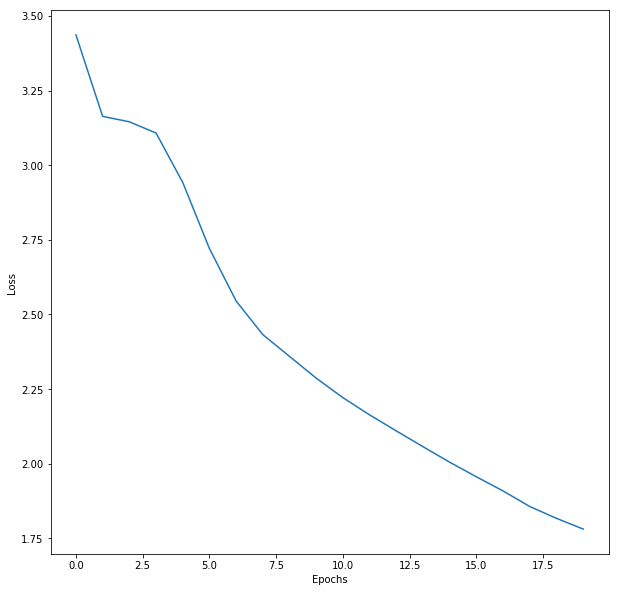

In [33]:
import matplotlib.pyplot as plt
import numpy as np
loss = history.history['loss']
newLoss = np.squeeze(loss)
plt.figure(figsize=(10,10))
plt.plot(newLoss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()